# 0. DEPENDENCIES

Fix for Jupyter Notebook imports:

In [119]:
import os
import sys

print(os.getcwd())

# sys.path.append("S:\Dropbox\\000 - CARND\CarND-T1-P5-Vehicle-Detection")

for path in sys.path: print(path)

S:\Dropbox\000 - CARND\CarND-T1-P5-Vehicle-Detection\src\notebooks

C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\python35.zip
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\DLLs
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\cycler-0.10.0-py3.5.egg
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\IPython\extensions
C:\Users\gmzco\.ipython
S:\Dropbox\000 - CARND\CarND-T1-P5-Vehicle-Detection


Remove the additional entry if needed:

In [120]:
# sys.path = sys.path[:-1]

for path in sys.path: print(path)


C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\python35.zip
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\DLLs
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\cycler-0.10.0-py3.5.egg
C:\Users\gmzco\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\IPython\extensions
C:\Users\gmzco\.ipython
S:\Dropbox\000 - CARND\CarND-T1-P5-Vehicle-Detection


Load all dependencies:

In [148]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle

from importlib import reload
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

import src.helpers.constants as C
import src.helpers.io as IO
import src.helpers.features as FT
import src.helpers.plot as PLT

# RELOAD:

reload(C)
reload(IO)
reload(FT)
reload(PLT)


<module 'src.helpers.plot' from 'S:\\Dropbox\\000 - CARND\\CarND-T1-P5-Vehicle-Detection\\src\\helpers\\plot.py'>

# 1. LOAD DATA

First, load all images filenames on the datasets, split into cars and non-cars. Print the counts and percentages of each to verify that the dataset is balanced.

In [122]:

files_cars = glob.glob("../../input/images/dataset/vehicles/*/*.png")
files_no_cars = glob.glob("../../input/images/dataset/non-vehicles/*/*.png")

count_cars = len(files_cars)
count_no_cars = len(files_no_cars)
count_total = count_cars + count_no_cars

percent_cars = 100 * count_cars / count_total
percent_no_cars = 100 * count_no_cars / count_total

print("    CAR IMAGES {0:5d} = {1:6.2f} %".format(count_cars, percent_cars))
print("NON-CAR IMAGES {0:5d} = {1:6.2f} %".format(count_no_cars, percent_no_cars))
print("-------------------------------")
print("         TOTAL {0:5d} = 100.00 %".format(count_total))


    CAR IMAGES  9226 =  49.54 %
NON-CAR IMAGES  9396 =  50.46 %
-------------------------------
         TOTAL 18622 = 100.00 %


The data looks quite balanced, so no need to do any augmentation. 

Next, preload them and check their total size to see if it's feasible to preload them all in different color spaces.

In [123]:

# Load all images (RGB only):
imgs_cars = IO.load_images_rgb(files_cars)
imgs_no_cars = IO.load_images_rgb(files_no_cars)

# Calculate their size by dumping them:
size_cars_b = sys.getsizeof(pickle.dumps(imgs_cars))
size_no_cars_b = sys.getsizeof(pickle.dumps(imgs_no_cars))
size_total_b = size_cars_b + size_no_cars_b


Print results in multiple units and calculate total for all channels:

In [124]:

size_cars_mb = size_cars_b / 1048576
size_no_cars_mb = size_no_cars_b / 1048576
size_total_mb = size_total_b / 1048576
size_all_spaces_mb = size_total_mb * (1 + len(C.COLOR_SPACES)) # RGB not included in C.COLOR_SPACES

size_all_spaces_gb = size_all_spaces_mb / 1024

print("          CAR IMAGES SIZE = {0:12.2f} B  = {1:6.2f} MB".format(size_cars_b, size_cars_mb))
print("      NON-CAR IMAGES SIZE = {0:12.2f} B  = {1:6.2f} MB".format(size_no_cars_b, size_no_cars_mb))
print("---------------------------------------------------")
print("               TOTAL SIZE = {0:12.2f} B  = {1:6.2f} MB".format(size_total_b, size_total_mb))
print("ESTIMATED ALL SPACES SIZE = {0:12.2f} MB = {1:6.2f} GB".format(size_all_spaces_mb, size_all_spaces_gb))


          CAR IMAGES SIZE = 113931311.00 B  = 108.65 MB
      NON-CAR IMAGES SIZE = 116030641.00 B  = 110.66 MB
---------------------------------------------------
               TOTAL SIZE = 229961952.00 B  = 219.31 MB
ESTIMATED ALL SPACES SIZE =      1754.47 MB =   1.71 GB


Free up space:

In [125]:

try: del imgs_cars
except NameError: pass # Was not defined
    
try: del imgs_no_cars
except NameError: pass # Was not defined


Load all images in all color spaces:

In [143]:

# CARS:

imgs_cars_rgb, \
imgs_cars_hsv, \
imgs_cars_luv, \
imgs_cars_hls, \
imgs_cars_yuv, \
imgs_cars_ycrcb, \
imgs_cars_gray = IO.load_images_all(files_cars)

# NON-CARS:

imgs_no_cars_rgb, \
imgs_no_cars_hsv, \
imgs_no_cars_luv, \
imgs_no_cars_hls, \
imgs_no_cars_yuv, \
imgs_no_cars_ycrcb, \
imgs_no_cars_gray = IO.load_images_all(files_no_cars)


Some basic checks:

In [144]:

# CARS:

assert len(imgs_cars_rgb) == count_cars
assert len(imgs_cars_hsv) == count_cars
assert len(imgs_cars_luv) == count_cars
assert len(imgs_cars_hls) == count_cars
assert len(imgs_cars_yuv) == count_cars
assert len(imgs_cars_ycrcb) == count_cars
assert len(imgs_cars_gray) == count_cars

# NON-CARS:

assert len(imgs_no_cars_rgb) == count_no_cars
assert len(imgs_no_cars_hsv) == count_no_cars
assert len(imgs_no_cars_luv) == count_no_cars
assert len(imgs_no_cars_hls) == count_no_cars
assert len(imgs_no_cars_yuv) == count_no_cars
assert len(imgs_no_cars_ycrcb) == count_no_cars
assert len(imgs_no_cars_gray) == count_no_cars


Let's see what the raw data of those images look like (helpful when using `matplotlib image`):

In [145]:

print(imgs_cars_rgb[0][0, 0], np.amin(imgs_cars_rgb[0]), np.amax(imgs_cars_rgb[0]))
print(imgs_cars_hsv[0][0, 0], np.amin(imgs_cars_hsv[0]), np.amax(imgs_cars_hsv[0]))
print(imgs_cars_luv[0][0, 0], np.amin(imgs_cars_luv[0]), np.amax(imgs_cars_luv[0]))
print(imgs_cars_hls[0][0, 0], np.amin(imgs_cars_hls[0]), np.amax(imgs_cars_hls[0]))
print(imgs_cars_yuv[0][0, 0], np.amin(imgs_cars_yuv[0]), np.amax(imgs_cars_yuv[0]))
print(imgs_cars_ycrcb[0][0, 0], np.amin(imgs_cars_ycrcb[0]), np.amax(imgs_cars_ycrcb[0]))
print(imgs_cars_gray[0][0, 0], np.amin(imgs_cars_gray[0]), np.amax(imgs_cars_gray[0]))


[156 168 163] 33 192
[ 78  18 168] 0 192
[173  92 139] 37 197
[ 78 162  16] 0 184
[165 124 126] 36 187
[164 122 127] 36 190
164 36 190


Let's see how the actual car images look like:

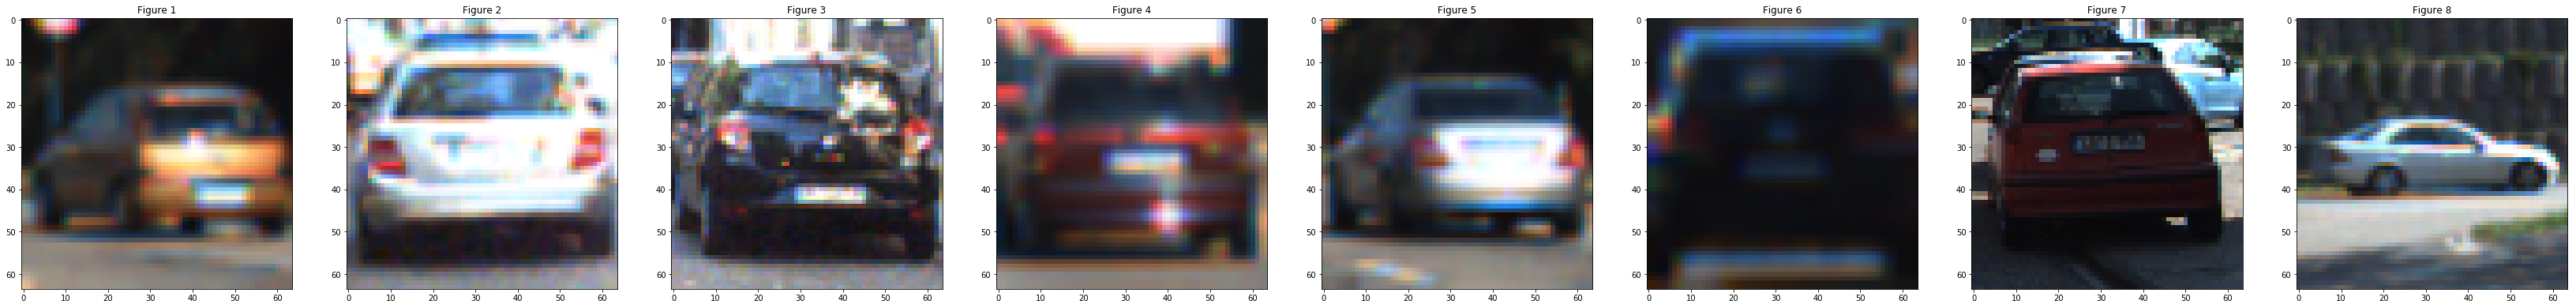

In [150]:

start = np.random.randint(0, count_cars)

PLT.showAll(imgs_cars_rgb[start:start+8], 8,)


And now the non-car ones:

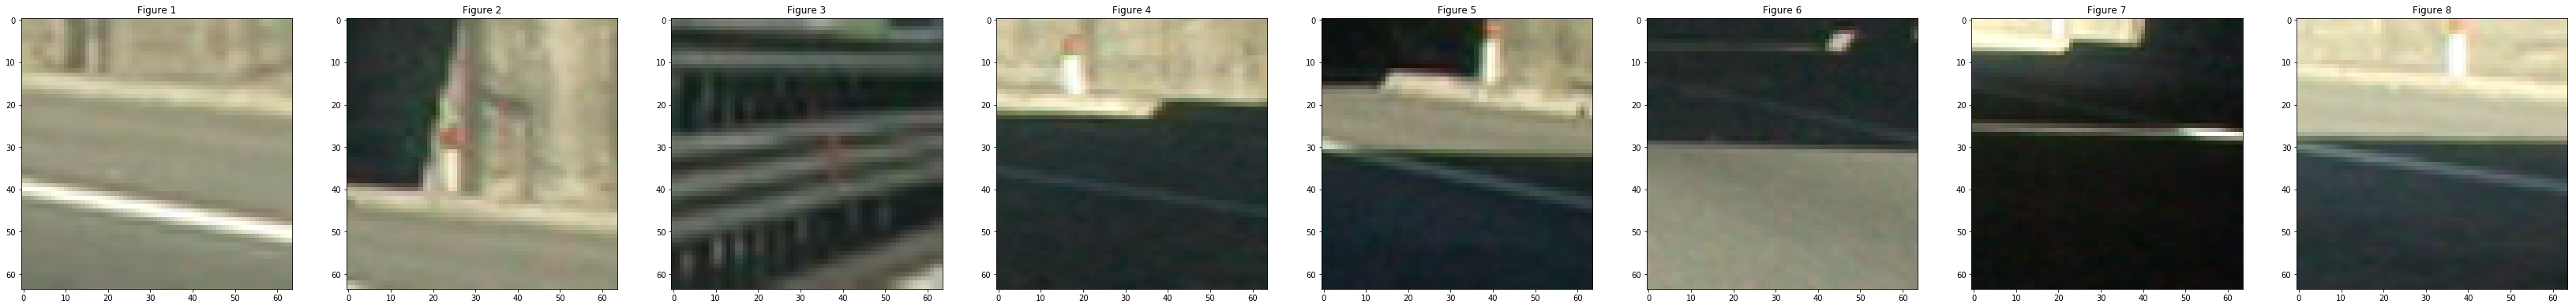

In [151]:

start = np.random.randint(0, count_no_cars)

PLT.showAll(imgs_no_cars_rgb[start:start+8], 8,)


Free up space:

In [141]:

# CARS:

try: del imgs_cars_rgb
except NameError: pass # Was not defined

try: del imgs_cars_hsv
except NameError: pass # Was not defined

try: del imgs_cars_luv
except NameError: pass # Was not defined

try: del imgs_cars_hls
except NameError: pass # Was not defined

try: del imgs_cars_yuv
except NameError: pass # Was not defined

try: del imgs_cars_ycrcb
except NameError: pass # Was not defined

try: del imgs_cars_gray
except NameError: pass # Was not defined

# NON-CARS:

try: del imgs_no_cars_rgb
except NameError: pass # Was not defined

try: del imgs_no_cars_hsv
except NameError: pass # Was not defined

try: del imgs_no_cars_luv
except NameError: pass # Was not defined

try: del imgs_no_cars_hls
except NameError: pass # Was not defined

try: del imgs_no_cars_yuv
except NameError: pass # Was not defined

try: del imgs_no_cars_ycrcb
except NameError: pass # Was not defined

try: del imgs_no_cars_gray
except NameError: pass # Was not defined


In [153]:

count_cars = len(imgs_cars_hls)
count_no_cars = len(imgs_no_cars_hls)
count_total = count_cars + count_no_cars

percent_cars = 100 * count_cars / count_total
percent_no_cars = 100 * count_no_cars / count_total

print("    CAR IMAGES {0:5d} = {1:6.2f} %".format(count_cars, percent_cars))
print("NON-CAR IMAGES {0:5d} = {1:6.2f} %".format(count_no_cars, percent_no_cars))
print("-------------------------------")
print("         TOTAL {0:5d} = 100.00 %".format(count_total))


    CAR IMAGES  9226 =  49.54 %
NON-CAR IMAGES  9396 =  50.46 %
-------------------------------
         TOTAL 18622 = 100.00 %


## SECTION'S CONCERNS, IMPROVEMENTS, TODOS...

- Should images that belong to the same sequence be grouped together so that half of each of them can go to a different subset (training and test)?
- __Images visualizations in different color spaces.__

# 2. EXTRACT FEATURES

First, let's quickly check how HOG features look like for car and non-car HLS images:

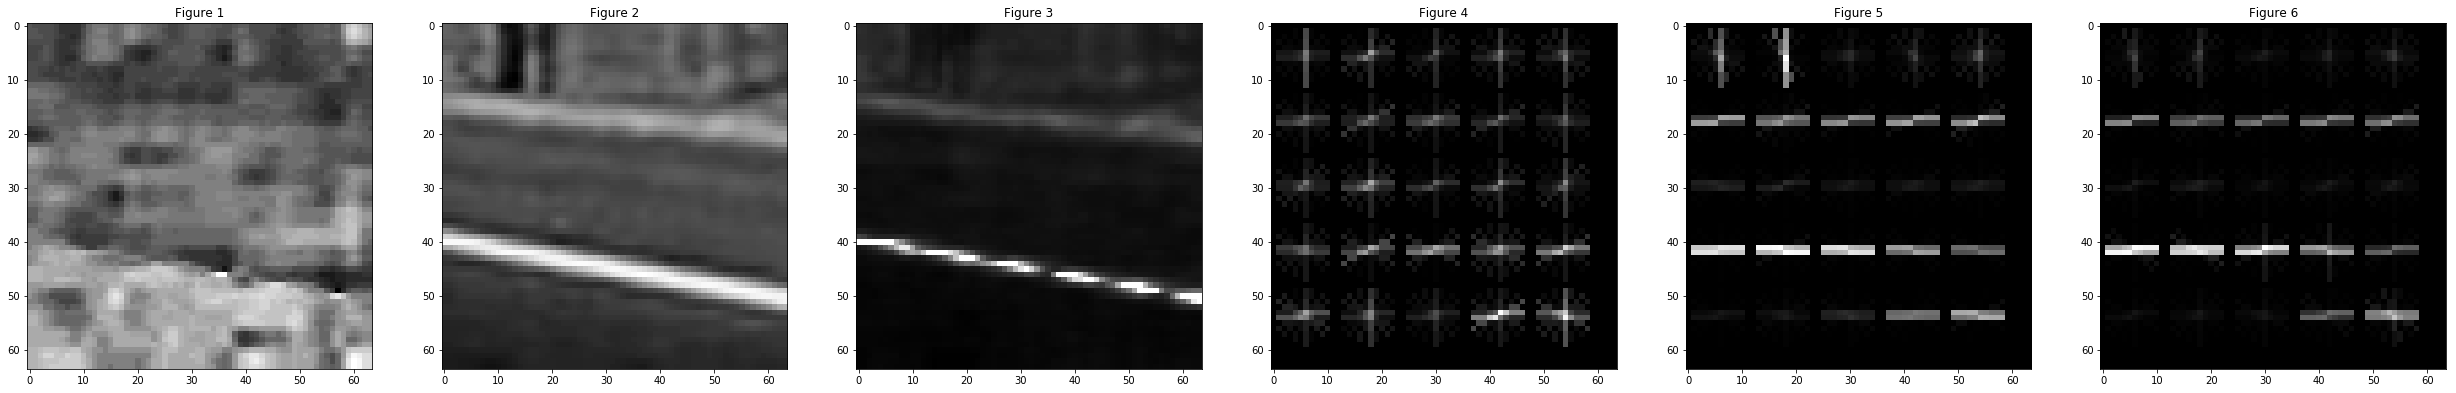

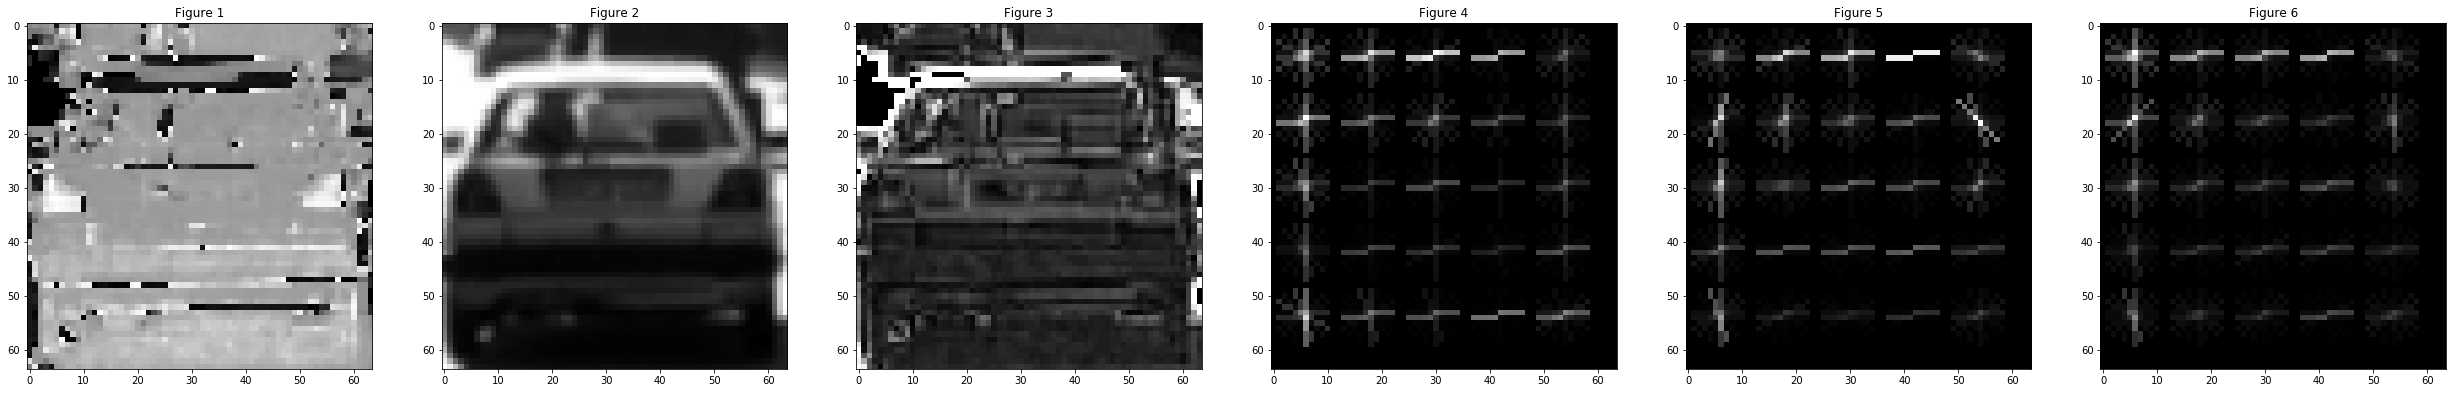

In [169]:

# CAR:

car_image = imgs_cars_hls[start]
car_channels = [car_image[:,:,0], car_image[:,:,1], car_image[:,:,2]]
car_hogs = FT.features_hog(car_image, 9, 12, 2, visualise=True)[2]

PLT.showAll(car_channels + car_hogs, 6, "gray")

# NON-CAR:

non_car_image = imgs_no_cars_hls[start]
non_car_channels = [non_car_image[:,:,0], non_car_image[:,:,1], non_car_image[:,:,2]]
non_car_hogs = FT.features_hog(non_car_image, 9, 12, 2, visualise=True)[2]

PLT.showAll(non_car_channels + non_car_hogs, 6, "gray")


Ok, so now we are ready to extract all the features from all the images:

In [154]:

# Use a subset to train params!

# TODO: Add channel to all feature methods or check how I did it in project 4
# TOOO: Plot hog and histograms (cars VS non cars)

ft_car_binned = FT.extract_binned_color(imgs_cars_hls, size=(8, 8))
ft_no_car_binned = FT.extract_binned_color(imgs_no_cars_hls, size=(8, 8))

print("BINNED")

ft_car_hist = FT.extract_histogram_color(imgs_cars_hls, bins=32)
ft_no_car_hist = FT.extract_histogram_color(imgs_no_cars_hls, bins=32)

print("HIST")

ft_car_hog = FT.extract_hog(imgs_cars_hls, orients=9, ppc=12, cpb=2)
ft_no_car_hog = FT.extract_hog(imgs_no_cars_hls, orients=9, ppc=12, cpb=2)

print("HOG")


BINNED
HIST
HOG


 # 3. TRAIN CLASSIFIER (SVM)
 
 First, generate the final features vectors:

In [159]:

features_car = FT.combine_features((ft_car_binned, ft_car_hist, ft_car_hog))
features_no_car = FT.combine_features((ft_no_car_binned, ft_no_car_hist, ft_no_car_hog))

print('Feature vector length:', len(features_car[0]))


Feature vector length: 2016


Next, train a classifier with them and check some stats about its performance:

In [174]:

# Create an array stack of feature vectors and a vector of labels:
X = np.vstack((features_car, features_no_car)).astype(np.float64)   
y = np.hstack((np.ones(count_cars), np.zeros(count_no_cars)))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

# Create a Pipeline to be able to save scaler and classifier together:

clf = Pipeline([
    ('SCALER',     StandardScaler()),
    ('CLASSIFIER', LinearSVC(loss="hinge"))
    # ('CLASSIFIER', SVC(kernel="linear"))
])

# Pipeline. See: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# SVC VS LinearSVC. See: https://stackoverflow.com/questions/35076586/linearsvc-vs-svckernel-linear-conflicting-arguments


# Train the model:

t0 = time.time()

clf.fit(X_train, y_train)

t = time.time() - t0


# Output model's stats:

print("    TRAINING TIME = {0:2.4f} SEC".format(t))
print("TRAINING ACCURACY = {0:2.4f} %".format(clf.score(X_train, y_train)))
print("    TEST ACCURACY = {0:2.4f} %".format(clf.score(X_test, y_test)))

print("\nCONFUSION MATRIX (TRAIN / TEST / ALL):")

t0 = time.time()

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_pred = clf.predict(X)

t = time.time() - t0

print(confusion_matrix(y_train, y_train_pred))
print(confusion_matrix(y_test, y_test_pred))
print(confusion_matrix(y, y_pred))

print("PREDICTION TIME = {0:2.4f} MS".format(t, 1000 * t / (2 * count_total)))


# TODO: Automatically adjust classifier's params!

# LinearSVC:
# 0.9859 with loss="hinge"
# 0.9840 with C=100, loss="hinge"
# 0.9825 with nothing
# 0.9825 with C=10, loss="hinge"
# 0.9823 with dual=False
# 0.9823 with C=10

# SVC kernel="linear": SLOW
# 0.9865 with nothing
# 0.9862 with C=10
# 0.9854 with C=100

# SVC kernel="rbf": SUPER SLOW
# 0.9913 with nothing
# 0.9620 with gamma=0.01

# SVC kernel="poly": SLOW
# 0.9524 with nothing

# DecisionTreeClassifier:
# 0.9657 with min_samples_split=10
# 0.9631 with max_depth=32
# 0.9628 with min_samples_split=32
# 0.9626 with min_samples_split=10, max_depth=16
# 0.9620 with max_depth=8
# 0.9614 with nothing
# 0.9614 with min_samples_split=10, max_depth=32
# 0.9592 with max_depth=16
# 0.9566 with min_samples_split=10, max_depth=8
# 0.9544 with criterion="entropy"

# GaussianNB:
# 0.8229 with nothing

# RandomForestClassifier:
# 0.9882 with n_estimators=20
# 0.9856 with n_estimators=24
# 0.9856 with n_estimators=32
# 0.9797 with nothing

# AdaBoostClassifier: SUPER SLOW
# 0.9891 with nothing
# 0.9885 with n_estimators=100


# ALL ABOVE WITH HSV IMAGES. BELOW, LinearSVC with loss="hinge" in other color spaces:
# RGB: 0.9820 - OK (very few false positives). Does not detect black car.
# HSV: 0.9859 - Lots of false positives (especially with bigger window). Does not detect black car.
# LUV: 0.9896 - Lots of false positives (especially with bigger window). Detects both cars.
# HSL: 0.9851 - OK (still problematic with bigger window). Detects both cars.
# YUV: 0.9893 - Lots of false positives (especially with bigger window). Detects both cars.
# YCRCB: 0.9842 - Lots of false positives (especially with bigger window). Detects both cars.

# RGB (binned + hist) + HSL (hog): 0.9814 - Lots of false positives. Does not detect black car.
# RGB (hog) + HSL (binned + hist): 0.9859 - Lots of false positives (especially with bigger window) quite ok.

    TRAINING TIME = 6.5654 SEC
TRAINING ACCURACY = 0.9999 %
    TEST ACCURACY = 0.9847 %

CONFUSION MATRIX (TRAIN / TEST / ALL):
[[7507    1]
 [   1 7388]]
[[1850   38]
 [  19 1818]]
[[9357   39]
 [  20 9206]]
PREDICTION TIME = 1.2114 MS


# 4. ANALYZE ERRORS

Let's see which images are incorrectly classified:

In [ ]:
false_positives = []
false_negatives = []

for truth, prediction in zip(y, y_pred, ):
    if truth != prediction:
        if truth == 0 and prediction == 1:
           false_positives.append() 

# 5. SAVE THE MODEL

In [175]:
# TODO: Save each model with the params used?

joblib.dump(clf, "../../output/models/classifier.pkl")

# See: http://scikit-learn.org/stable/modules/model_persistence.html

['../../output/models/classifier.pkl']